In [70]:
# %load qbo_fub2netcdf.py
#!/usr/bin/python3
'''
Read QBO data from the following file: http://www.geo.fu-berlin.de/met/ag/strat/produkte/qbo/qbo.dat
'''

import matplotlib as mpl
from matplotlib import dates
import datetime
import xarray as xr
import pandas as pd
import numpy as np
import cftime
from dateutil.relativedelta import relativedelta


def read_singapore(nmonth,nyear):
    headerlines = []
    ye = []
    dats = []
    count = 0
    date = []
    #url = "http://www.geo.fu-berlin.de/met/ag/strat/produkte/qbo/singapore.dat"
    #download(url,"Data/singapore.dat")
    with open('../QBO/qbo_data/singapore.dat') as file:
        for i in range(3):
            headerlines.append(file.readline().strip())
        for year in range(1987,nyear):
            if year == nyear:
                data = np.zeros([nmonth,15])*np.nan
            else:
                data = np.zeros([12,15])*np.nan
            ye.append(file.readline().strip())
            file.readline()
            if (year < 1997):
                data = np.zeros([12,15])*np.nan
                for i in range(14):
                    cols = file.readline()
                    cols = cols.strip().split()
                    for j in range(1,13):
                        if i == 1:
                            date.append(datetime.datetime(year, j, 1))
                        data[j-1,i] = float(cols[j])
            else:
                for i in range(15):
                    cols = file.readline()
                    cols = cols.strip().split()
                    for j in range(1,13):
                        if j < nmonth+1 or year < nyear:
                            if i == 1:
                                # print(year)
                                date.append(datetime.datetime(year, j, 1))
                            data[j-1,i] = float(cols[j])
            dats.extend([list(i) for i in data])
            file.readline()
            count = count + 1
    pressure = [100, 90, 80, 70, 60, 50, 45, 40, 35, 30, 25, 20, 15, 12, 10]
    altitude = -7*np.log(np.array(pressure)/1013.25)
    fds = list(mpl.dates.date2num(date))
    # for i in range(np.shape(dats)[0]-np.shape(fds)[0]):
    #     fds.append(np.nan)
    fds = np.array(fds)
    # print(headerlines)
    return np.array(dats).T[::-1],fds,pressure,altitude, 

def read_qbo():
    #url = "http://www.geo.fu-berlin.de/met/ag/strat/produkte/qbo/qbo.dat"
    #download(url,"Data/singapore_winds_1953-2017_qbo.dat")

    # Open the file to read the header
    with open('../QBO/qbo_data/qbo.dat', 'r') as file:
        # Read the first 9 lines and print them
        header_lines = [file.readline().strip() for _ in range(9)]
        # print("\n".join(header_lines))
    
    data = np.genfromtxt('../QBO/qbo_data/qbo.dat', skip_header=9,
                         dtype=['S6', 'S4', 'i4', 'i1', 'i4', 'i1', 'i4', 'i1', 'i4', 'i1', 'i4', 'i1', 'i4', 'i1', 'i4', 'i1'],
                         names=['station', 'date', 'p70', 'n70', 'p50', 'n50', 'p40', 'n40', 'p30', 'n30', 'p20', 'n20', 'p15', 'n15', 'p10', 'n10'],
                         delimiter=[6, 4, 6, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2],
                         filling_values=-999999, missing_values=' ')

    # Print the header information
    # print(np.unique(data['station']))

    station = np.char.decode(data['station'], 'utf-8').astype(str)
    station = np.char.strip(station)
    
    #data = np.genfromtxt('../QBO/qbo_data/qbo.dat',skip_header=9,dtype=['S6','S4','i4','i1','i4','i1','i4','i1','i4','i1','i4','i1','i4','i1','i4','i1'],names=['station','date','p70','n70','p50','n50','p40','n40','p30','n30','p20','n20','p15','n15','p10','n10'],delimiter=[6,4,6,2,5,2,5,2,5,2,5,2,5,2,5,2],filling_values=-999999,missing_values=' ')#
    date = []
    station = []
    for i in range(len(data)):
        station.append(data['station'][i])
        if int(data['date'][i]) > 5000:
            date.append(datetime.datetime.strptime('19'+(data['date'][i]).decode('UTF-8'),'%Y%m'))
        else:
            date.append(datetime.datetime.strptime('20'+(data['date'][i]).decode('UTF-8'),'%Y%m'))

    fds = mpl.dates.date2num(date)
    up = np.array(list([data['p70'],data['p50'],data['p40'],data['p30'],data['p20'],data['p15'],data['p10']]))
    un = np.array(list([data['n70'],data['n50'],data['n40'],data['n30'],data['n20'],data['n15'],data['n10']]))
    
    pressure = [70,50,40,30,20,15,10]
    altitude = -7*np.log(np.array(pressure)/1013.25)
    return up,fds,pressure,altitude,station,un

def convert2netcdf(date,dateaddmonth,u,pressure,fname,station):

    station_id = []
    station_name = []
    latitude = []
    longitude = []

    for s_code in station:
        if s_code == '91700':
            station_id.append(s_code)
            station_name.append('CANTON ISLAND')
            latitude.append(-(2 + 46 / 60))       #   2°46' S
            longitude.append(-(171 + 43 / 60))    # 171°43' W
        elif s_code in ['48968', '48698', '48964', '48694', '08694']:
            if s_code.endswith('4'):
                station_id.append('48694')
            elif s_code.endswith('8'):
                station_id.append('48698')
            else:
                # Handle other cases or raise an error if needed
                raise ValueError(f"Unsupported station code: {s_code}")
            station_name.append('SINGAPORE')
            latitude.append(1 + 22 / 60)          #   1°22' N
            longitude.append(103 + 55 / 60) # 103°55' E
        elif s_code == '43599':
            station_id.append(s_code)
            station_name.append('GAN/MALEDIVES')
            latitude.append(-(41 / 60))           #   0°41' S
            longitude.append(73 + 9 / 60)         #  73°09' E
        else:
            # Handle other cases or raise an error if needed
            raise ValueError(f"Unsupported station code: {s_code}")

    # Replace NaN values in 'u' with a specific fill value (e.g., -9999)
    #u = np.where(np.isnan(u), -9999, u)
    ds = xr.Dataset({
        'u': (['time', 'pressure'], u),
        'station_id': (['time'], station_id),
        'station_name': (['time'], station_name),
        'latitude': (['time'], latitude),
        'longitude': (['time'], longitude),
    }, 
    coords={
        'pressure': pressure,
        'time': date,
    })
    
    # Create a new variable for the quality flag
    ds['u_qc'] = xr.DataArray(
        np.where((ds['u'] >= -200) & (ds['u'] <= 200), 0, 1),
        coords=ds['u'].coords, dims=ds['u'].dims)
    
    # Ensure that u_qc has the correct data type
    ds['u_qc'] = ds['u_qc'].astype(np.int32)

    # Create time_bounds variable with appropriate shape
    time_bounds = xr.DataArray(
    np.array([date, dateaddmonth]).T,
    dims=['time', 'bounds'],
    attrs={'units': 'days since 1950-01-01 00:00:00'})
    
    # Create the 'time_bounds' variable
    ds['time_bounds'] = time_bounds
    time_bounds.attrs = {'long_name': 'Time Bounds', 
                         'standard_name': 'time_bounds',
                         'units': 'days since 1950-01-01 00:00:00'}
    
    # Add the 'time_bounds' variable to the dataset's coordinates
    ds.coords['time_bounds'] = time_bounds
    
    # Store the time bounds in the 'bounds' attribute of the 'time' variable    
    ds['time'].attrs     = {'standard_name': 'time', 
                            'long_name': 'Time',
                            'units': 'days since 1950-01-01 00:00:00', 
                            'cell_methods':  'time: mean over calendar_month',
                            'bounds': 'time_bounds'}  
    ds['pressure'].attrs = {'standard_name': 'air_pressure', 
                            'long_name': 'Atmospheric Pressure',
                            'units': 'hPa',
                            'axis': 'Z'}
    ds['u'].attrs        = {'standard_name': 'eastward_wind', 
                            'long_name': 'Eastward Wind',
                            'units': 'm/s',
                            'cell_methods': 'time: mean over calendar_month',
                            '_FillValue': np.nan,
                            'u_qc': 0}

    # Add attributes for latitude and longitude variables
    ds['latitude'].attrs = {'long_name': 'Latitude', 'standard_name': 'latitude', 'units': 'degrees_north'}
    ds['longitude'].attrs = {'long_name': 'Longitude', 'standard_name': 'longitude', 'units': 'degrees_east'}

    ds['u_qc'].attrs = {'long_name': 'Quality flag for eastward wind', 
                    'flag_values': np.array([0, 1], dtype=np.int32),  # Ensure consistent data type
                    'flag_meanings': 'interpolated missing'}

    ds.attrs = {'Conventions': 'CF-1.6, CF-1.7, CF-1.8, IOOS-1.2, ACDD-1.3', 
                'title': 'Monthly mean zonal winds', 
                'summary': 'Collection of tropical winds originally from the FU Berlin to represent QBO data',
                'history': 'Created by Tobias Kerzenmacher using FUB processing chain', 
                'source': 'FUB and Singapore radiosondes',
                'comment': 'Monthly mean zonal winds at the levels 100, 90, 80, 70, 60, 50, 45, 40, 35, 30, 25, 20, 15, 12, and 10-hPa from Radiosonde data of of the three radiosonde stations Canton Island (closed 1967), Gan/Maledive Islands (closed 1975), and Singapore near the equator from 1953 to the present.',
                'institution': 'Karlsruhe Institute of Technology (KIT), Institute of Meteorology and Climate Research (IMK), Germany',
                'institution_id': 'ROR:04t3en479',
                'license': 'CC-BY 4.0',
                'keywords': 'QBO, radiosonde, zonal wind',
                'frequency': '1M',
                'creator_url': 'https://orcid.org/0000-0001-8413-0539',
                'creator_email': 'kerzenmacher@kit.edu',
                'contact': 'kerzenmacher@kit.edu',
                'creation_date': datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'),
                'further_info_url': 'https://www.atmohub.kit.edu/english/807.php',
                'references': 'Barbara Naujokat (1986) doi: https://doi.org/10.1175/1520-0469(1986)043<1873:AUOTOQ>2.0.CO;2  Christian Marquardt (1998) Die tropische QBO und dynamische Prozesse in der Stratosphäre. PhD Thesis, Met. Abh. FU-Berlin, Serie A, Band 9/Heft 4, Verlag Dietrich Reimer Berlin, 260 S.',
                'standard_name_vocabulary': 'CF Standard Name Table, Version 83',
                'crs': 'wgs84'
               }

    # Change the data type of the 'pressure' variable
    ds['pressure'] = ds['pressure'].astype(np.float64)

    # Change the data type of the 'time' variable
    ds['time'] = ds['time'].astype(np.float64)

    # Change the data type of the 'u' variable
    ds['u'] = ds['u'].astype(np.float64)

    # Change the data type of the 'time_bounds' variable
    ds['time_bounds'] = ds['time_bounds'].astype(np.float64)

    # Write to NetCDF file
    ds.to_netcdf(fname)
    return(ds)

#def main():

# Read data from QBO
up1,fds1,pressure1,altitude1,station,un = read_qbo()

# Read data from Singapore
# In order to read the Singapore data the end year and the fractional month are necessary
nmonth = np.shape(up1)[1]%12 # number of months above a whole year
nyear = mpl.dates.num2date(fds1[-1]).year
up2,fds2,pressure,altitude = read_singapore(nmonth,nyear)

# Create an empty array of eastward winds over 15 altitudes and the total number of months
tnmoth = np.shape(up1)[1] # total number of months
up = np.zeros([15,tnmoth])*np.nan

# Stack time data from QBO and Singapore
fds = fds1
fds[-fds2.size:] = fds2
fds = np.array(fds)

# Assemble eastward wind data into a single array for the QBO data only certain altitudes are present 
up1      = up1 * 1.
up1[up1  < -10000] = np.nan
up[3,:]  = up1[0,:]
up[5,:]  = up1[1,:]
up[7,:]  = up1[2,:]
up[9,:]  = up1[3,:]
up[11,:] = up1[4,]
up[12,:] = up1[5,:]
up[14,:] = up1[6,:]

# Stack the Singapore data which are available at all altitudes at the end of the QBO data
up[-up2.shape[0]:,-up2.shape[1]:] = up2
#ind = ~np.isnan(up)
#time,press = np.meshgrid(fds,pressure)
#uu = np.array(up[ind])*.1
# time = time[ind]
# press = press[ind]

# Convert date strings to datetime objects
time = mpl.dates.num2date(fds)

# Add one month to the date range so that time bounds can be defined
offset = relativedelta(months=1)
timeaddmonth =[pd.to_datetime(t) + offset for t in time]

# Convert dates to CFTime-compatible format
date = cftime.date2num(time, 'days since 1950-01-01 00:00:00', 'standard')
dateaddmonth = cftime.date2num(timeaddmonth, 'days since 1950-01-01 00:00:00', 'standard')

# Create netCDF file
# fname = 'eastward_wind_'+str(time[0].year)+str(time[0].month)+'.nc'
fname = 'eastward_wind_{}{:02d}.nc'.format(time[0].year, time[0].month)
ds=convert2netcdf(date,dateaddmonth,up.T*0.1,pressure,fname, [x.decode("utf-8").strip() for x in station])
    

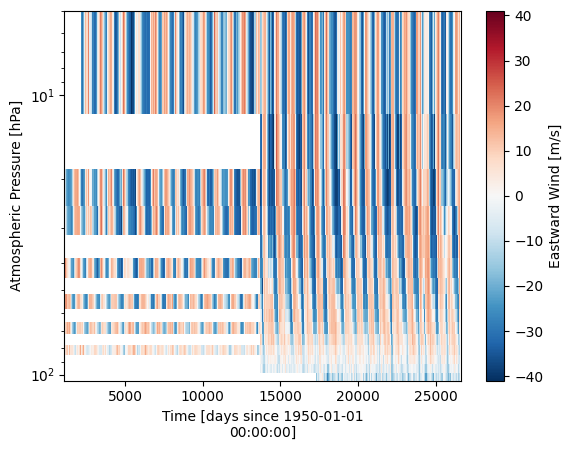

In [71]:
ds.u.plot.imshow(y='pressure',yscale='log', yincrease=False)